In [1]:
# Imports

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import math
import re
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, confusion_matrix

import torch
import torchvision
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
#from torch.utils.data import (
#    DataLoader,
#)  # Gives easier dataset managment and creates mini batches
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset

In [2]:
def pad(filename):
    # Load array
    original_array = np.load(filename)
    # Divide into pMHC and TCR
    pmhc = np.concatenate((original_array[original_array[:, 20] == 1], original_array[original_array[:, 21] == 1]))
    tcr = np.concatenate((original_array[original_array[:, 22] == 1], original_array[original_array[:, 23] == 1]))
    # Padding pMHC (only at the end)
    padding_size = (192 - pmhc.shape[0])
    end_pad = np.zeros((padding_size, pmhc.shape[1]))
    pmhc_padded = np.concatenate((pmhc, end_pad))
    # Padding TCR
    padding_size = (228 - tcr.shape[0]) / 2
    front_pad = np.zeros((math.floor(padding_size), tcr.shape[1]))
    end_pad = np.zeros((math.ceil(padding_size), tcr.shape[1]))
    tcr_padded = np.concatenate((front_pad, tcr, end_pad))
    # Concatanate pMHC and TCR
    array_padded = np.concatenate((pmhc_padded, tcr_padded))
    return array_padded

def load_data(filelist):
    padded_length = 192 + 228
    X = np.zeros(shape=(len(filelist), padded_length, 142))
    y = np.zeros(shape=len(filelist))
    for i in range(len(filelist)):
        filename = filelist[i]
        final_array = pad(filename)
        X[i] = final_array
        r = re.search(r'pos', filename)
        if r:
            y[i] = 1
        else:
            y[i] = 0
    return X, y


In [3]:
p1_filelist = glob.glob("../data/train_data/*1p*")[:300]
X_train, y_train = load_data(p1_filelist)
#X_train_negatives = X_train[y_train == 0]
#X_train_positives = X_train[y_train == 1]
#y_train_negatives = y_train[y_train == 0]
#y_train_positives = y_train[y_train == 1]
#print(X_train_positives)
#print(X_train_negatives[0:200].shape)
#print(X_train_positives[0:10].shape)
#X_train = np.concatenate((X_train_negatives[0:200], X_train_positives[0:10]))
#y_train = np.concatenate((y_train_negatives[0:200], y_train_positives[0:10]))
nsamples, nx, ny = X_train.shape
print(nsamples,nx,ny)

p2_filelist = glob.glob("../data/train_data/*2p*")[100:200]
X_test, y_test = load_data(p2_filelist)
nsamples, nx, ny = X_test.shape
print(nsamples,nx,ny)

300 420 142
100 420 142


In [4]:
print("Percent positive samples:")
len(y_train[y_train == 1])/len(y_train)*100

Percent positive samples:


19.333333333333332

In [5]:
# make the data set into one dataset that can go into dataloader
train_ds = []
for i in range(len(X_train)):
    train_ds.append([np.transpose(X_train[i]), y_train[i]])

In [6]:
test_ds = []
for i in range(len(X_test)):
    test_ds.append([np.transpose(X_test[i]), y_test[i]])

In [7]:
bat_size = 128
train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)

In [8]:
bat_size = 128
test_ldr = torch.utils.data.DataLoader(test_ds,batch_size=bat_size, shuffle=True)

In [9]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model

In [17]:
# Hyperparameters
input_size = 420
num_classes = 1
learning_rate = 0.001

class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=142, out_channels=100, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv1_bn = nn.BatchNorm1d(100)
        self.conv2 = nn.Conv1d(in_channels=100, out_channels=50, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(1300,10)
        self.fc2 = nn.Linear(10, num_classes)

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x) 
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        #x = torch.sigmoid(self.fc2(x)) 
        x =self.fc2(x)
        
        return x
    
# Initialize network
net = Net(input_size=input_size, num_classes=num_classes).to(device)

In [21]:
# Hyperparameters
num_classes = 1
learning_rate = 0.01
class Net(nn.Module):
    def __init__(self,  num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=142, out_channels=100, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv1_bn = nn.BatchNorm1d(100)
        self.conv2 = nn.Conv1d(in_channels=100, out_channels=50, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv2_bn = nn.BatchNorm1d(50)
        self.fc1 = nn.Linear(1300,225)
        torch.nn.init.kaiming_uniform_(self.fc1.weight)
        self.fc2 = nn.Linear(225,10)
        torch.nn.init.kaiming_uniform_(self.fc2.weight)
        self.fc3 = nn.Linear(10, num_classes)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
    def forward(self, x):
        #print(x.size())
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_bn(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
# Initialize network
net = Net(num_classes=num_classes).to(device)

In [22]:
# Loss and optimizer
criterion = nn.BCELoss() 
optimizer = optim.SGD(net.parameters(), lr=learning_rate)



In [ ]:
# Training the model
num_epochs = 10 #100


train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
cur_loss = 0
losses = []
loss_val = 0
val_losses = []

valid_acc_test = []

for epoch in range(num_epochs):
    print(epoch+1)
    cur_loss = 0
    val_loss = 0
    
    net.train()
    train_preds, train_targs = [], [] 
    for batch_idx, (data, target) in enumerate(train_ldr):
        X_batch =  data.float().clone().detach().requires_grad_(True)
        target_batch = torch.tensor(np.array(target), dtype = torch.float).unsqueeze(1)

        optimizer.zero_grad()
        output = net(X_batch)
        batch_loss = criterion(output, target_batch) 
        batch_loss.backward()
        optimizer.step()
        
        #preds = np.round(output.detach())
        preds = np.round(output.detach())
        train_targs += list(np.array(target_batch))
        train_preds += list(preds.data.numpy())
        cur_loss += batch_loss   

    losses.append(cur_loss / len(X_train))
        
    
    net.eval()
    ### Evaluate validation
    val_preds, val_targs = [], []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_ldr): ###
            x_batch_val = data.float().clone().detach()#.unsqueeze(1)
            y_batch_val = target.float().clone().detach().unsqueeze(1)
            output = net(x_batch_val)
            val_batch_loss = criterion(output, y_batch_val)
            #preds = np.round(output.detach())
            preds = np.round(output.detach())
            val_preds += list(preds.data.numpy()) 
            val_targs += list(np.array(y_batch_val))
            val_loss += val_batch_loss  
            
        val_losses.append(val_loss / len(X_test))
        
        train_acc_cur = accuracy_score(train_targs, train_preds)  
        valid_acc_cur = accuracy_score(val_targs, val_preds) 

        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)

epoch = np.arange(1,len(train_acc)+1)
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Epoch'), plt.ylabel('Acc')
#plt.savefig('/home/projects/ht3_aim/people/alsj/cd4cd8/data/figures/alpha/CNN_Accuracy.png')


epoch = np.arange(1,len(train_acc)+1)
plt.figure()
plt.plot(epoch, losses, 'r', epoch, val_losses, 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Epoch'), plt.ylabel('Loss')
#plt.savefig('/home/projects/ht3_aim/people/alsj/cd4cd8/data/figures/alpha/CNN_Loss.png')


1
2
3
4
5


In [18]:
confusion_matrix(train_targs, train_preds)

array([[  0, 242],
       [  0,  58]])

In [19]:
confusion_matrix(val_targs, val_preds)

array([[ 0, 88],
       [ 0, 12]])

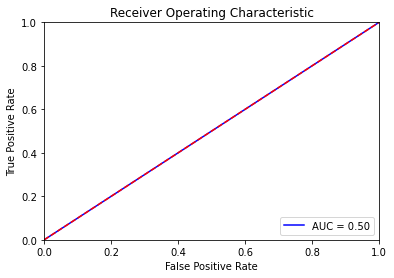

In [27]:
# ROC
fpr, tpr, threshold = metrics.roc_curve(train_targs, train_preds)
roc_auc = metrics.auc(fpr, tpr)

# plot ROC
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

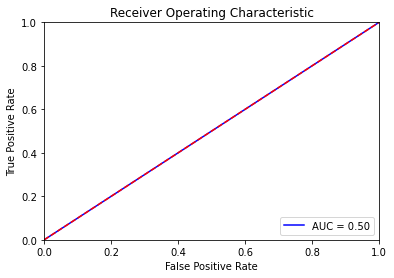

In [46]:
# ROC
fpr, tpr, threshold = metrics.roc_curve(val_targs, val_preds)
roc_auc = metrics.auc(fpr, tpr)

# plot ROC
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()